`Q1. Install the Package`\
To get started with Weights & Biases you'll need to install the appropriate Python package.

For this we recommend creating a separate Python environment, for example, you can use conda environments, and then install the package there with pip or conda.

In [ ]:
!pip install wandb

In [ ]:
!pip install -r requirements.txt

Once you installed the package, run the command `wandb --version` and check the output.

What's the version that you have?

In [1]:
!wandb --version

wandb, version 0.15.3


`Q2. Download and preprocess the data`

We'll use the Green Taxi Trip Records dataset to predict the amount of tips for each trip.

Download the data for January, February and March 2022 in parquet format from here.

Use the script `preprocess_data.py` located in the folder homework-wandb to preprocess the data.

The script will:

- initialize a Weights & Biases run.
- load the data from the folder <TAXI_DATA_FOLDER> (the folder where you have downloaded the data)
- fit a DictVectorizer on the training set (January 2022 data)
- save the preprocessed datasets and the DictVectorizer to your Weights & Biases dashboard as an artifact of type `preprocessed_dataset`

`preprocess_data.py`

In [ ]:
import os
import pickle
import click
import pandas as pd

import wandb

from sklearn.feature_extraction import DictVectorizer


def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)


def read_dataframe(filename: str):
    df = pd.read_parquet(filename)

    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df


def preprocess(df: pd.DataFrame, dv: DictVectorizer, fit_dv: bool = False):
    df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]
    categorical = ["PU_DO"]
    numerical = ["trip_distance"]
    dicts = df[categorical + numerical].to_dict(orient="records")
    if fit_dv:
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return X, dv


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--raw_data_path", help="Location where the raw NYC taxi trip data was saved"
)
@click.option("--dest_path", help="Location where the resulting files will be saved")
def run_data_prep(
    wandb_project: str,
    wandb_entity: str,
    raw_data_path: str,
    dest_path: str,
    dataset: str = "green",
):
    # Initialize a Weights & Biases run
    wandb.init(project=wandb_project, entity=wandb_entity, job_type="preprocess")

    # Load parquet files
    df_train = read_dataframe(
        os.path.join(raw_data_path, f"{dataset}_tripdata_2022-01.parquet")
    )
    df_val = read_dataframe(
        os.path.join(raw_data_path, f"{dataset}_tripdata_2022-02.parquet")
    )
    df_test = read_dataframe(
        os.path.join(raw_data_path, f"{dataset}_tripdata_2022-03.parquet")
    )

    # Extract the target
    target = "tip_amount"
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    # Fit the DictVectorizer and preprocess data
    dv = DictVectorizer()
    X_train, dv = preprocess(df_train, dv, fit_dv=True)
    X_val, _ = preprocess(df_val, dv, fit_dv=False)
    X_test, _ = preprocess(df_test, dv, fit_dv=False)

    # Create dest_path folder unless it already exists
    os.makedirs(dest_path, exist_ok=True)

    # Save DictVectorizer and datasets
    dump_pickle(dv, os.path.join(dest_path, "dv.pkl"))
    dump_pickle((X_train, y_train), os.path.join(dest_path, "train.pkl"))
    dump_pickle((X_val, y_val), os.path.join(dest_path, "val.pkl"))
    dump_pickle((X_test, y_test), os.path.join(dest_path, "test.pkl"))

    artifact = wandb.Artifact("NYC-Taxi", type="preprocessed_dataset")
    artifact.add_dir(dest_path)
    wandb.log_artifact(artifact)


if __name__ == "__main__":
    run_data_prep()

Your task is to download the datasets and then execute this from the command line:

In [ ]:
python preprocess_data.py \
  --wandb_project "mlops-zoomcamp-137" \
  --wandb_entity "stephen137" \
  --raw_data_path "$(pwd)/Data" \
  --dest_path ./output

Tip: go to `02-experiment-tracking/homework-wandb/` folder before executing the command and change the value of `<WANDB_PROJECT_NAME>` to the name of your Weights & Biases project, `<WANDB_USERNAME>` to your Weights & Biases username, and `<TAXI_DATA_FOLDER>` to the location where you saved the data.



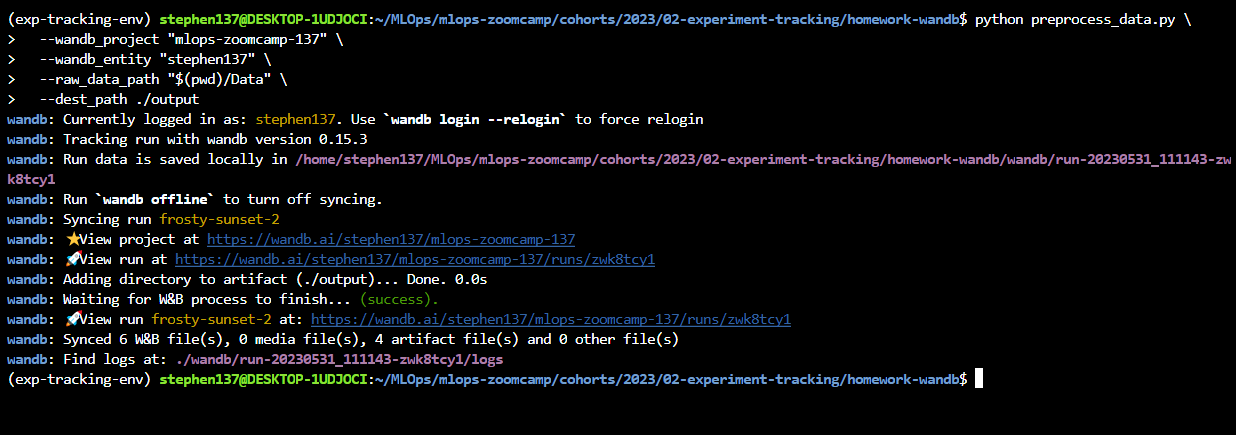


Once you navigate to the Files tab of your artifact on your Weights & Biases page, what's the size of the saved DictVectorizer file?

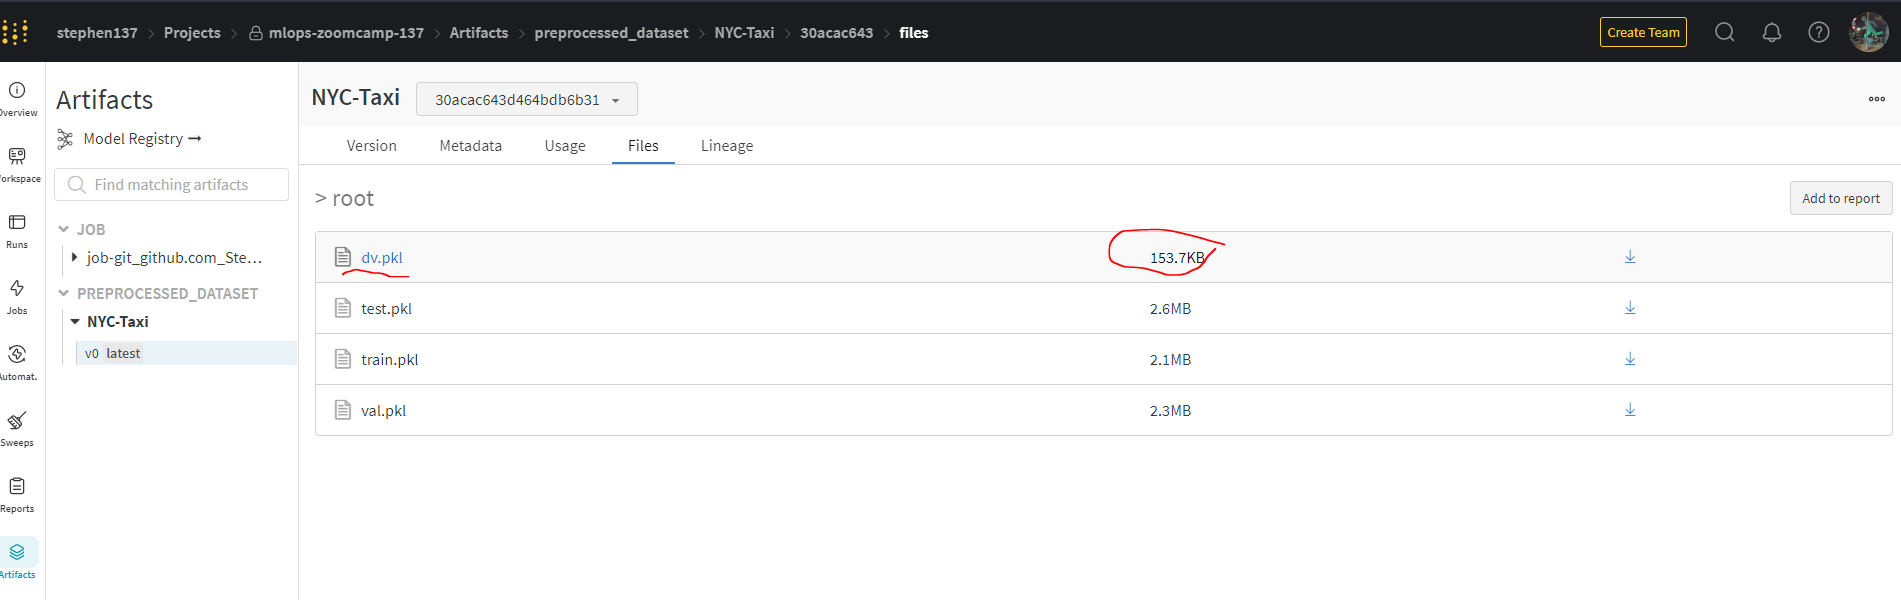



- 54 kB
- `154 kB`
- 54 MB
- 154 MB

`Q3. Train a model with Weights & Biases logging`

We will train a RandomForestRegressor (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder `homework-wandb`.

The script will:

- initialize a Weights & Biases run.
- load the preprocessed datasets by fetching them from the Weights & Biases artifact previously created,
- train the model on the training set,
- calculate the MSE score on the validation set and log it to Weights & Biases,
- save the trained model and log it to Weights & Biases as a model artifact.

Your task is to **modify* the script to enable to add Weights & Biases logging, execute the script and then check the Weights & Biases run UI to check that the experiment run was properly tracked.

`TODO 1:` log mse to Weights & Biases under the key "MSE"

`TODO 2:` log regressor.pkl as an artifact of type model, refer to the [official docs](https://docs.wandb.ai/guides/artifacts) in order to know more about logging artifacts.

Modify the following script :

`train.py`

In [ ]:
import os
import pickle
import click

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--data_artifact",
    help="Address of the Weights & Biases artifact holding the preprocessed data",
)
@click.option("--random_state", default=0, help="Random state")
@click.option("--max_depth", default=10, help="Max tree depth")
def run_train(
    wandb_project: str,
    wandb_entity: str,
    data_artifact: str,
    max_depth: int,
    random_state: int,
):
    # Initialize a Weights & Biases run
    wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        job_type="train",
        config={"max_depth": max_depth, "random_state": random_state},
    )

    # Fetch the preprocessed dataset from artifacts
    artifact = wandb.use_artifact(data_artifact, type="preprocessed_dataset")
    data_path = artifact.download()

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    # Define the XGBoost Regressor Mode, train the model and perform prediction
    rf = RandomForestRegressor(max_depth=max_depth, random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    # TODO: Log `mse` to Weights & Biases under the key `"MSE"`

    with open("regressor.pkl", "wb") as f:
        pickle.dump(rf, f)

    # TODO: Log `regressor.pkl` as an artifact of type `model`


if __name__ == "__main__":
    run_train()

`train.py` # modified

In [ ]:
import os
import pickle
import click

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--data_artifact",
    help="Address of the Weights & Biases artifact holding the preprocessed data",
)
@click.option("--random_state", default=0, help="Random state")
@click.option("--max_depth", default=10, help="Max tree depth")
def run_train(
    wandb_project: str,
    wandb_entity: str,
    data_artifact: str,
    max_depth: int,
    random_state: int,
):
    # Initialize a Weights & Biases run
    wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        job_type="train",
        config={"max_depth": max_depth, "random_state": random_state},
    )

    # Fetch the preprocessed dataset from artifacts
    artifact = wandb.use_artifact(data_artifact, type="preprocessed_dataset")
    data_path = artifact.download()

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    # Define the XGBoost Regressor Mode, train the model and perform prediction
    rf = RandomForestRegressor(max_depth=max_depth, random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    # TODO: Log `mse` to Weights & Biases under the key `"MSE"`
    wandb.log({'MSE': mse}) # added

    with open("regressor.pkl", "wb") as f:
        pickle.dump(rf, f)

    # TODO: Log `regressor.pkl` as an artifact of type `model`
    model_artifact = wandb.Artifact("regressor_model", type="model") # added
    model_artifact.add_file("regressor.pkl") # added
    wandb.log_artifact(model_artifact) # added

if __name__ == "__main__":
    run_train()

You can then run the **modified** script using :

In [ ]:
python train.py \
  --wandb_project "mlops-zoomcamp-137" \
  --wandb_entity "stephen137" \
  --data_artifact "stephen137/mlops-zoomcamp-137/NYC-Taxi:v0"

- `Tip 1:` You can find the artifact address under the Usage tab in the respective artifact's page.

- `Tip 2:` don't modify the hyperparameters of the model to make sure that the training will finish quickly.


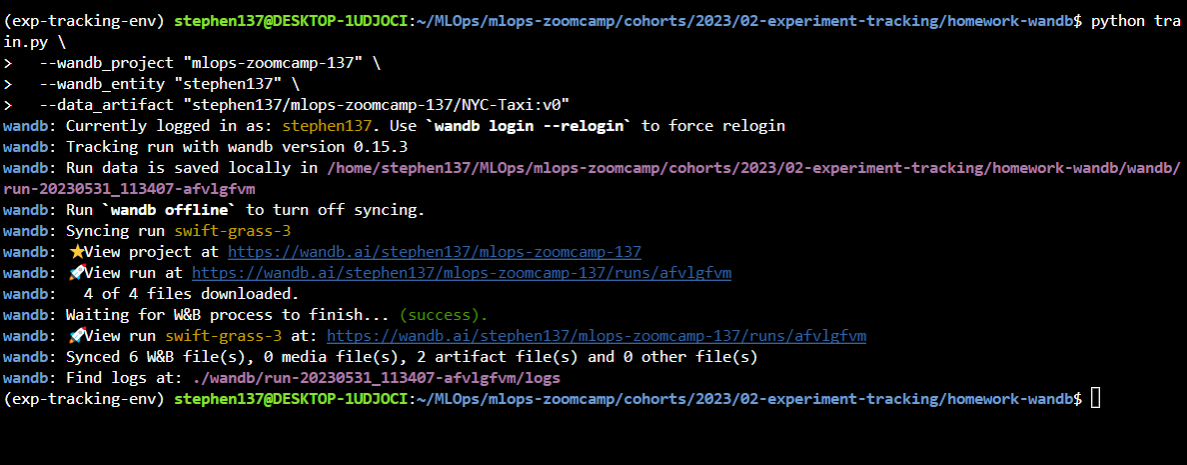


Once you have successfully ran the script, navigate the Overview section of the run in the Weights & Biases UI and scroll down to the Configs. 

What is the value of the max_depth parameter:

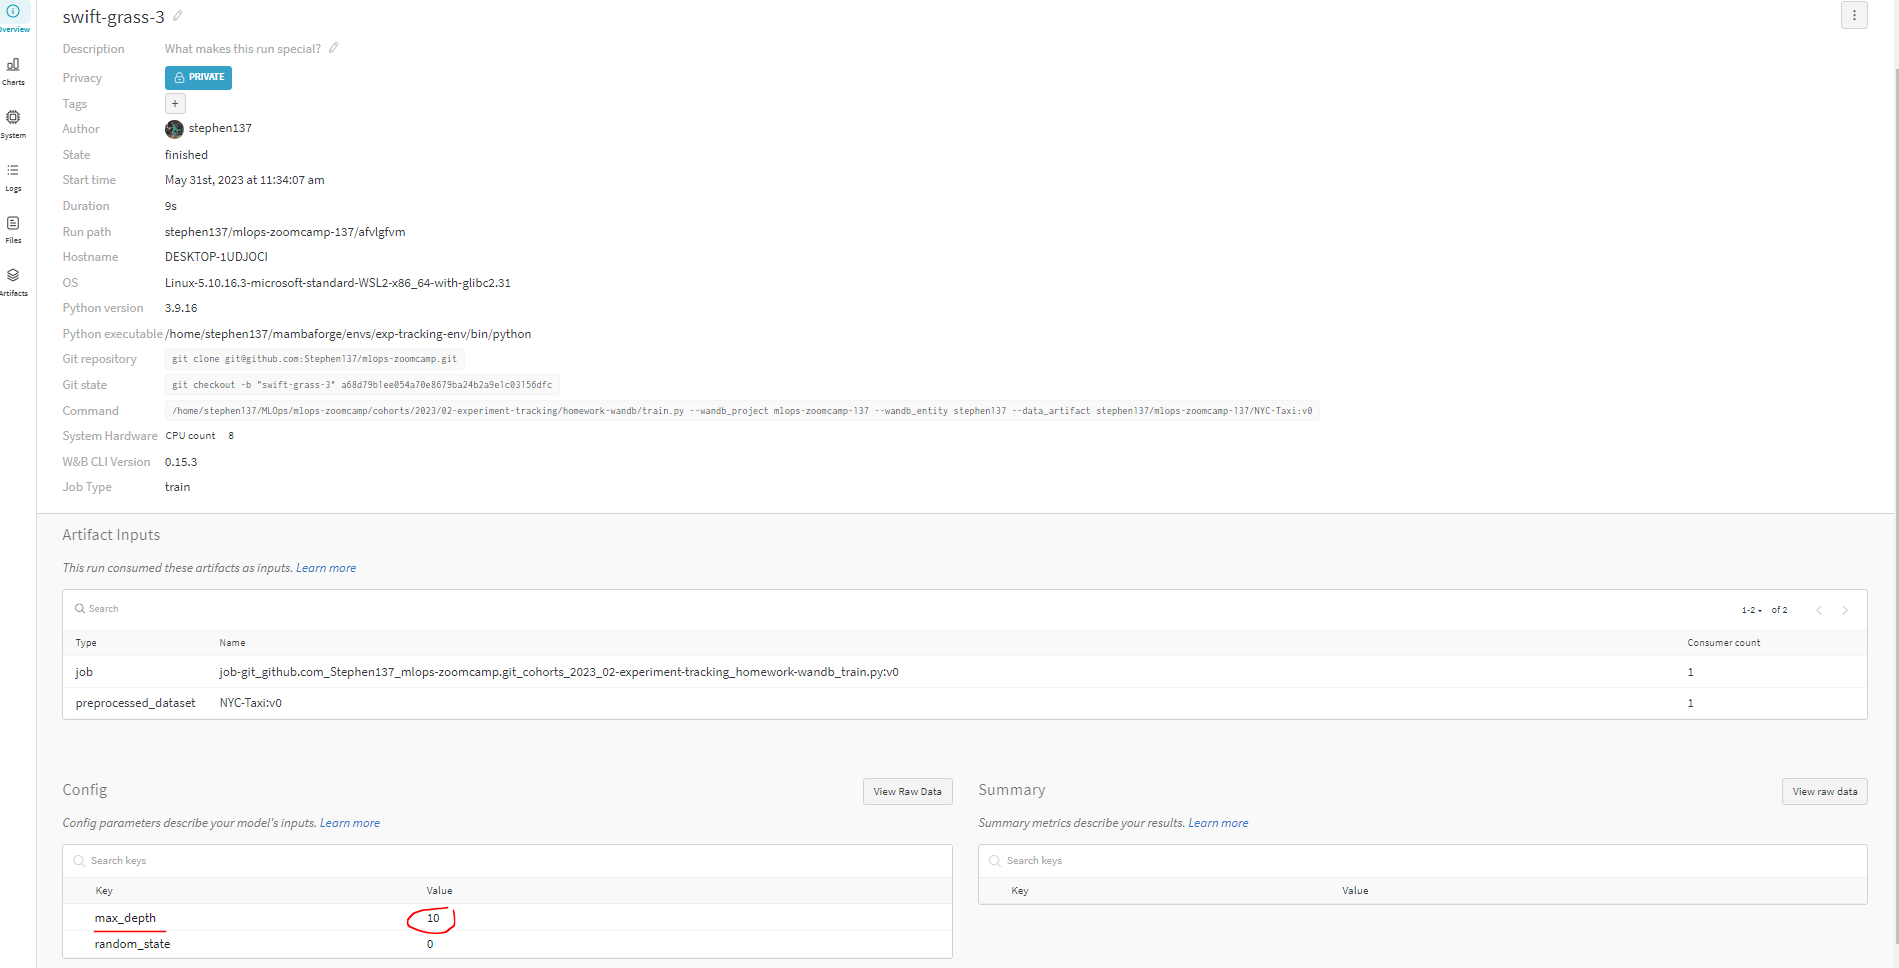

- 4
- 6
- 8
- `10`

`Q4. Tune model hyperparameters`

Now let's try to reduce the validation error by tuning the hyperparameters of the RandomForestRegressor using [Weights & Biases Sweeps](https://docs.wandb.ai/guides/sweeps). We have prepared the script `sweep.py` for this exercise in the homework-wandb directory.

Your task is to **modify** `sweep.py` to pass the parameters `n_estimators`, `min_samples_split` and `min_samples_leaf` from config to RandomForestRegressor inside the `run_train()` function. Then we will run the sweep to figure out not only the best best of hyperparameters for training our model, but also to analyze the most optimum trends in different hyperparameters. 

`sweep.py`

In [ ]:
import os
import pickle
import click
from functools import partial

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def run_train(data_artifact: str):
    wandb.init()
    config = wandb.config

    # Fetch the preprocessed dataset from artifacts
    artifact = wandb.use_artifact(data_artifact, type="preprocessed_dataset")
    data_path = artifact.download()

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    # Define the XGBoost Regressor Mode, train the model and perform prediction
    # TODO: Pass the parameters n_estimators, min_samples_split, min_samples_leaf from `config` to `RandomForestRegressor`
    rf = RandomForestRegressor(max_depth=config.max_depth, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    wandb.log({"MSE": mse})

    with open("regressor.pkl", "wb") as f:
        pickle.dump(rf, f)

    artifact = wandb.Artifact(f"{wandb.run.id}-model", type="model")
    artifact.add_file("regressor.pkl")
    wandb.log_artifact(artifact)


SWEEP_CONFIG = {
    "method": "bayes",
    "metric": {"name": "MSE", "goal": "minimize"},
    "parameters": {
        "max_depth": {
            "distribution": "int_uniform",
            "min": 1,
            "max": 20,
        },
        "n_estimators": {
            "distribution": "int_uniform",
            "min": 10,
            "max": 50,
        },
        "min_samples_split": {
            "distribution": "int_uniform",
            "min": 2,
            "max": 10,
        },
        "min_samples_leaf": {
            "distribution": "int_uniform",
            "min": 1,
            "max": 4,
        },
    },
}


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--data_artifact",
    help="Address of the Weights & Biases artifact holding the preprocessed data",
)
@click.option("--count", default=5, help="Number of iterations in the sweep")
def run_sweep(wandb_project: str, wandb_entity: str, data_artifact: str, count: int):
    sweep_id = wandb.sweep(SWEEP_CONFIG, project=wandb_project, entity=wandb_entity)
    wandb.agent(sweep_id, partial(run_train, data_artifact=data_artifact), count=count)


if __name__ == "__main__":
    run_sweep()

`sweep.py` # modified

In [ ]:
import os
import pickle
import click
from functools import partial

import wandb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def run_train(data_artifact: str):
    wandb.init()
    config = wandb.config

    # Fetch the preprocessed dataset from artifacts
    artifact = wandb.use_artifact(data_artifact, type="preprocessed_dataset")
    data_path = artifact.download()

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    # Define the XGBoost Regressor Mode, train the model and perform prediction
    # TODO: Pass the parameters n_estimators, min_samples_split, min_samples_leaf from `config` to `RandomForestRegressor`
    rf = RandomForestRegressor(n_estimators=config.n_estimators,
        min_samples_split=config.min_samples_split, min_samples_leaf=config.min_samples_leaf, max_depth=config.max_depth, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    wandb.log({"MSE": mse})

    with open("regressor.pkl", "wb") as f:
        pickle.dump(rf, f)

    artifact = wandb.Artifact(f"{wandb.run.id}-model", type="model")
    artifact.add_file("regressor.pkl")
    wandb.log_artifact(artifact)


SWEEP_CONFIG = {
    "method": "bayes",
    "metric": {"name": "MSE", "goal": "minimize"},
    "parameters": {
        "max_depth": {
            "distribution": "int_uniform",
            "min": 1,
            "max": 20,
        },
        "n_estimators": {
            "distribution": "int_uniform",
            "min": 10,
            "max": 50,
        },
        "min_samples_split": {
            "distribution": "int_uniform",
            "min": 2,
            "max": 10,
        },
        "min_samples_leaf": {
            "distribution": "int_uniform",
            "min": 1,
            "max": 4,
        },
    },
}


@click.command()
@click.option("--wandb_project", help="Name of Weights & Biases project")
@click.option("--wandb_entity", help="Name of Weights & Biases entity")
@click.option(
    "--data_artifact",
    help="Address of the Weights & Biases artifact holding the preprocessed data",
)
@click.option("--count", default=5, help="Number of iterations in the sweep")
def run_sweep(wandb_project: str, wandb_entity: str, data_artifact: str, count: int):
    sweep_id = wandb.sweep(SWEEP_CONFIG, project=wandb_project, entity=wandb_entity)
    wandb.agent(sweep_id, partial(run_train, data_artifact=data_artifact), count=count)


if __name__ == "__main__":
    run_sweep()


We can then run the **modified** sweep using:

In [ ]:
python sweep.py \
  --wandb_project "mlops-zoomcamp-137" \
  --wandb_entity "stephen137" \
  --data_artifact "stephen137/mlops-zoomcamp-137/NYC-Taxi:v0"

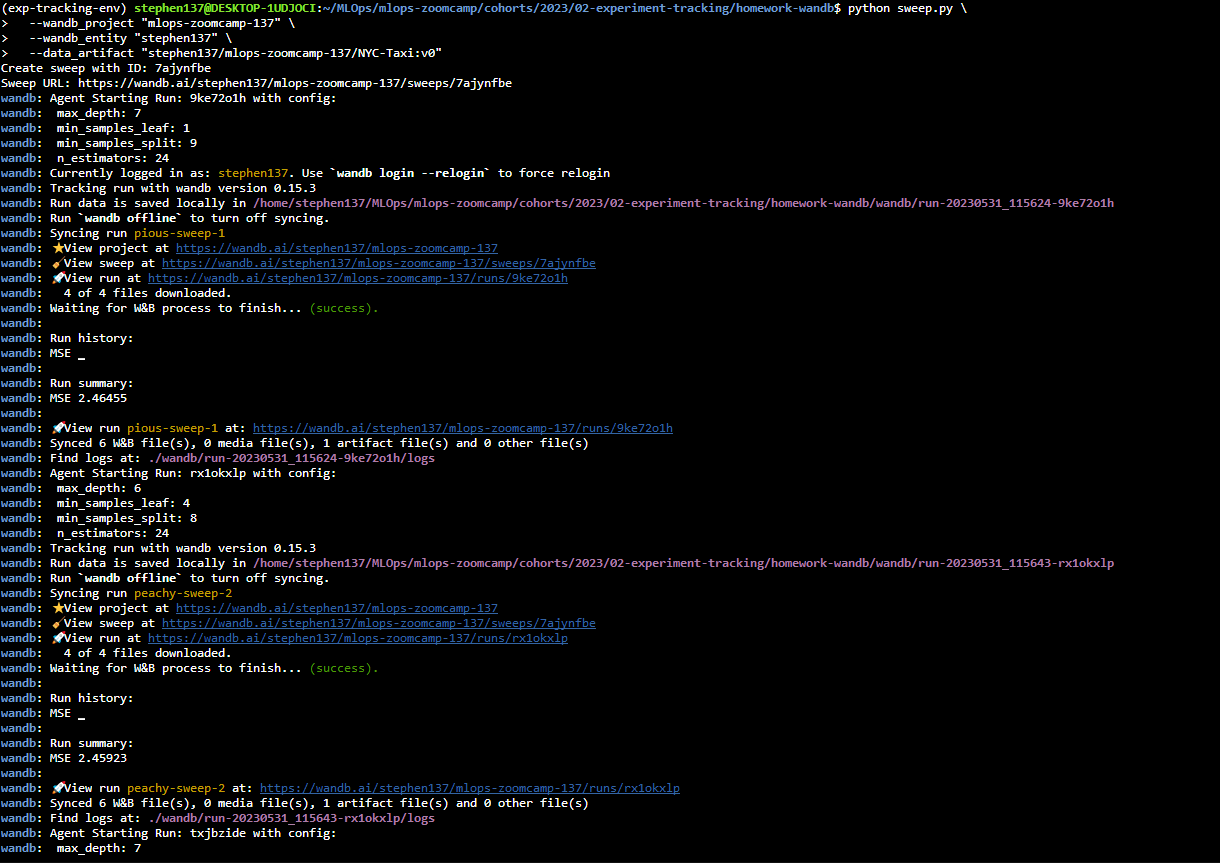
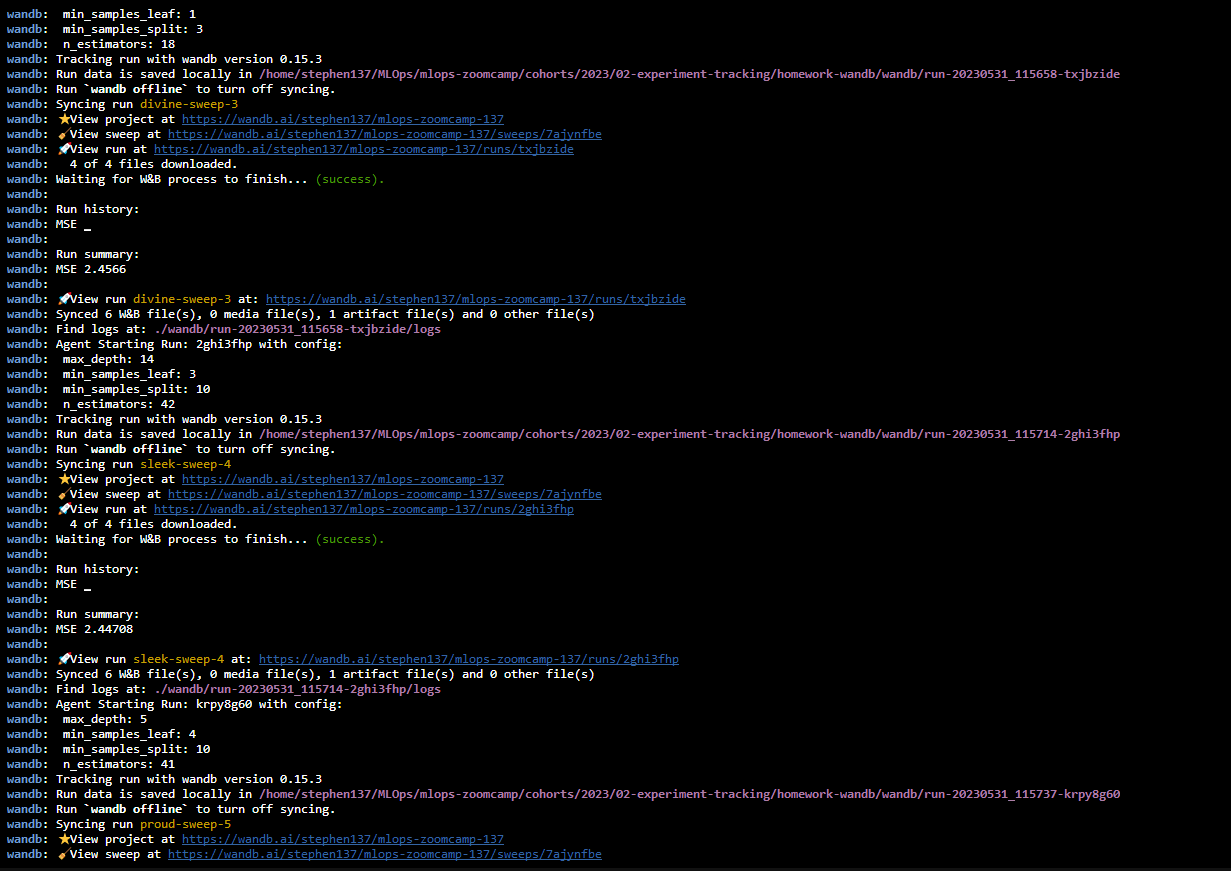
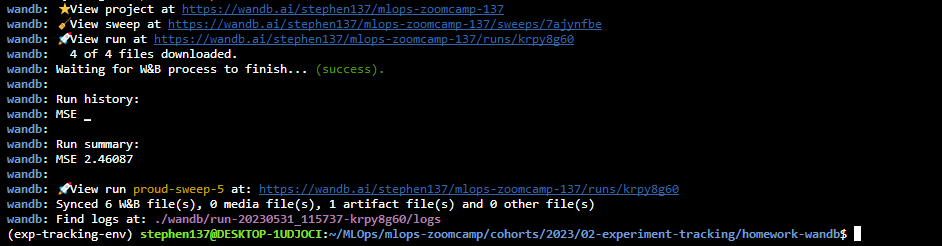


This command will run the sweep for 5 iterations using the Bayesian Optimization and HyperBand method proposed by the paper [BOHB: Robust and Efficient Hyperparameter Optimization at Scale](https://arxiv.org/abs/1807.01774). You can take a look at the sweep on your Weights & Biases dashboard, take a look at the `Parameter Inportance Panel` and the `Parallel Coordinates Plot` to determine, and analyze which hyperparameter is the most important:


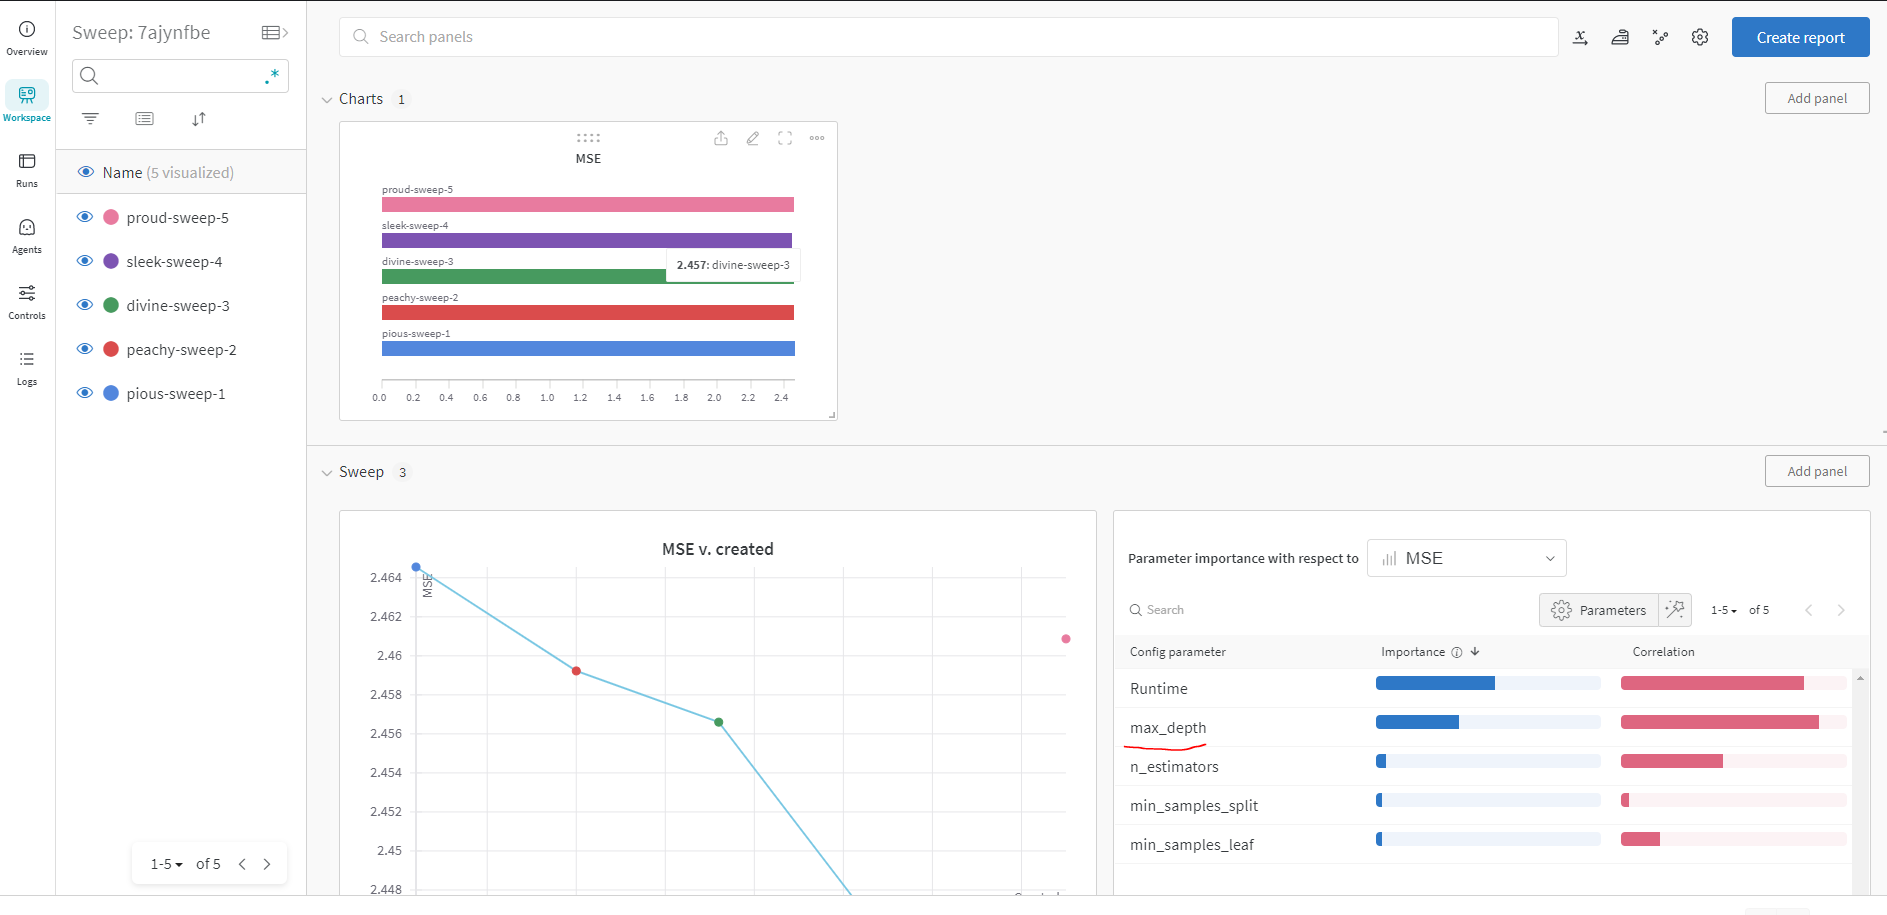



- `max_depth`
- n_estimators
- min_samples_split
- min_samples_leaf

`Q5. Link the best model to the model registry`

Now that we have obtained the optimal set of hyperparameters and trained the best model, we can assume that we are ready to test some of these models in production. In this exercise, you'll create a model registry and link the best model from the Sweep to the model registry.

First, you will need to create a Registered Model to hold all the candidate models for your particular modeling task. You can refer to [this section](https://docs.wandb.ai/guides/models/walkthrough#1-create-a-new-registered-model) of the official docs to learn how to create a registered model using the Weights & Biases UI.


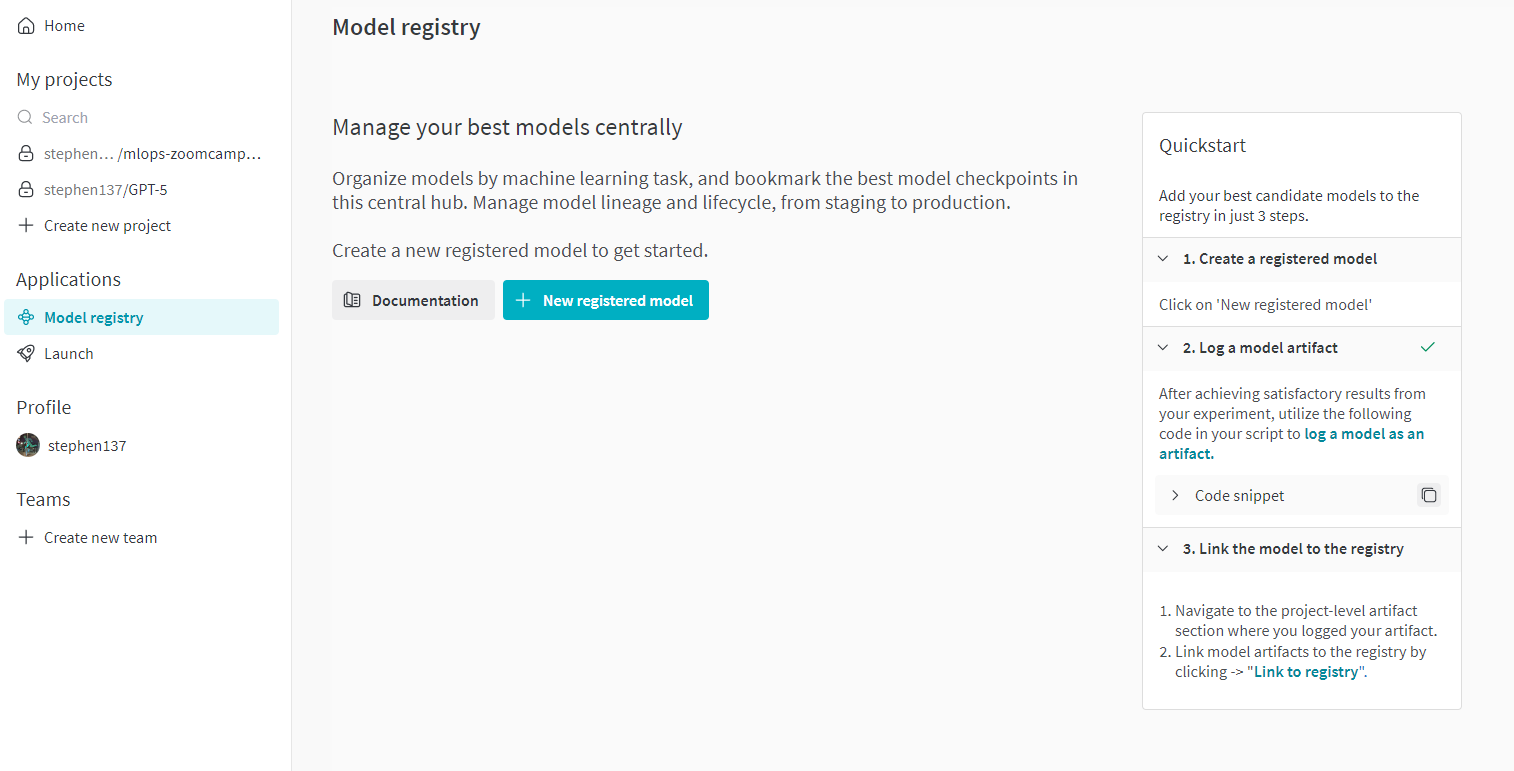

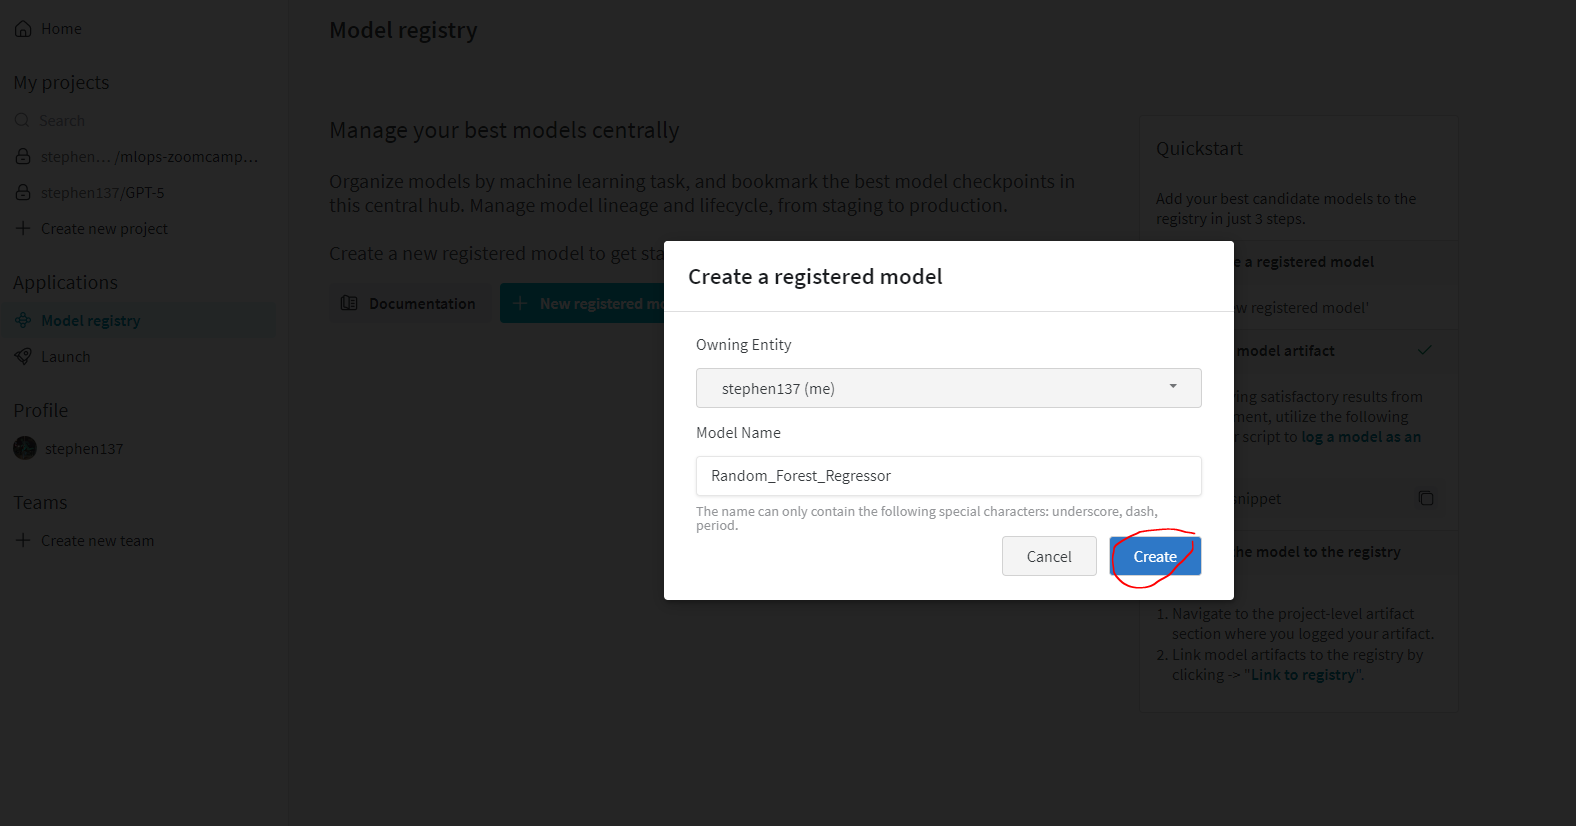


Once you have created the Registered Model successfully, you can navigate to the best run of your sweep, 


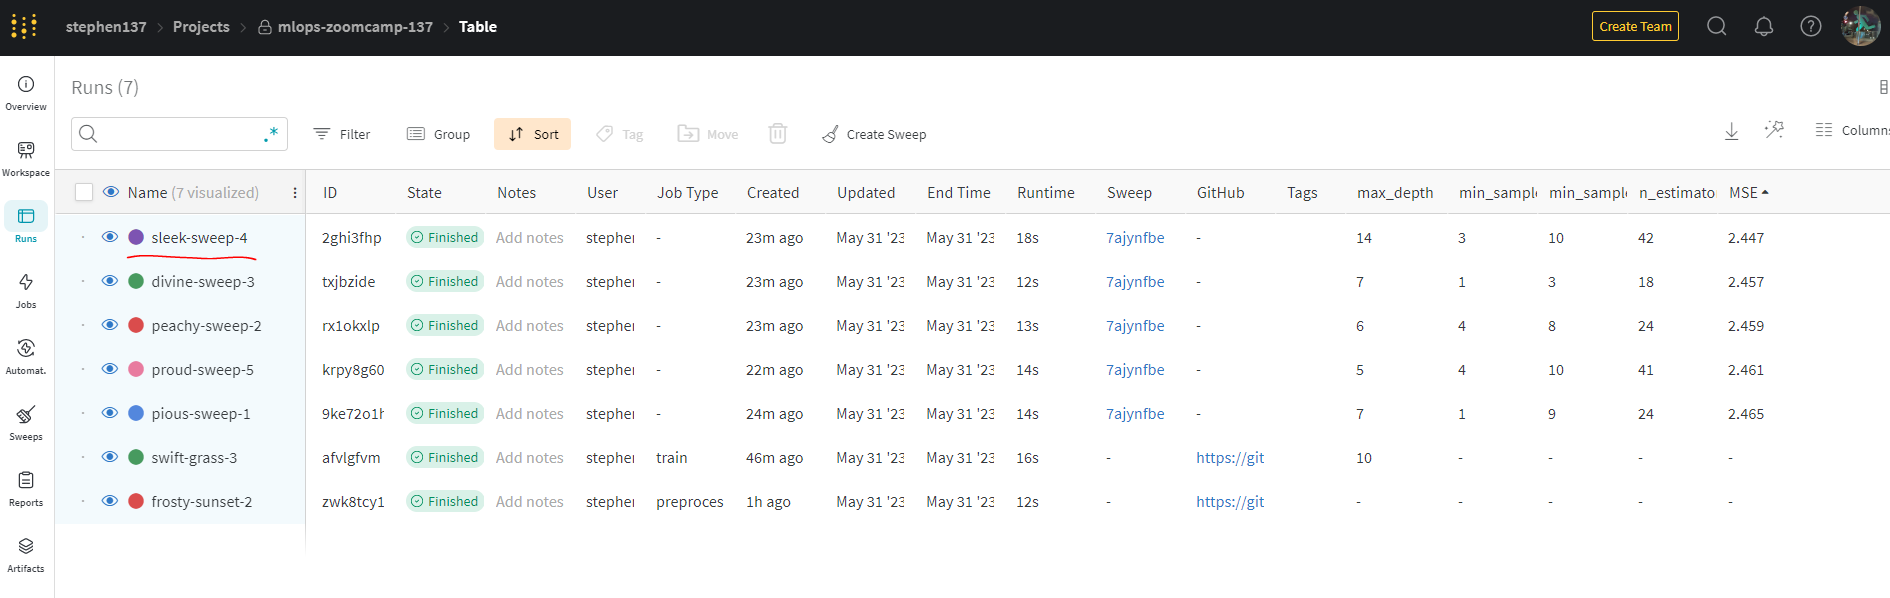



navigate to the `model artifact` created by the particular run, and click on the Link to Registry option from the UI. This would link the model artifact to the Registered Model. You can choose to add some suitable aliases for the Registered Model, such as production, best, etc.


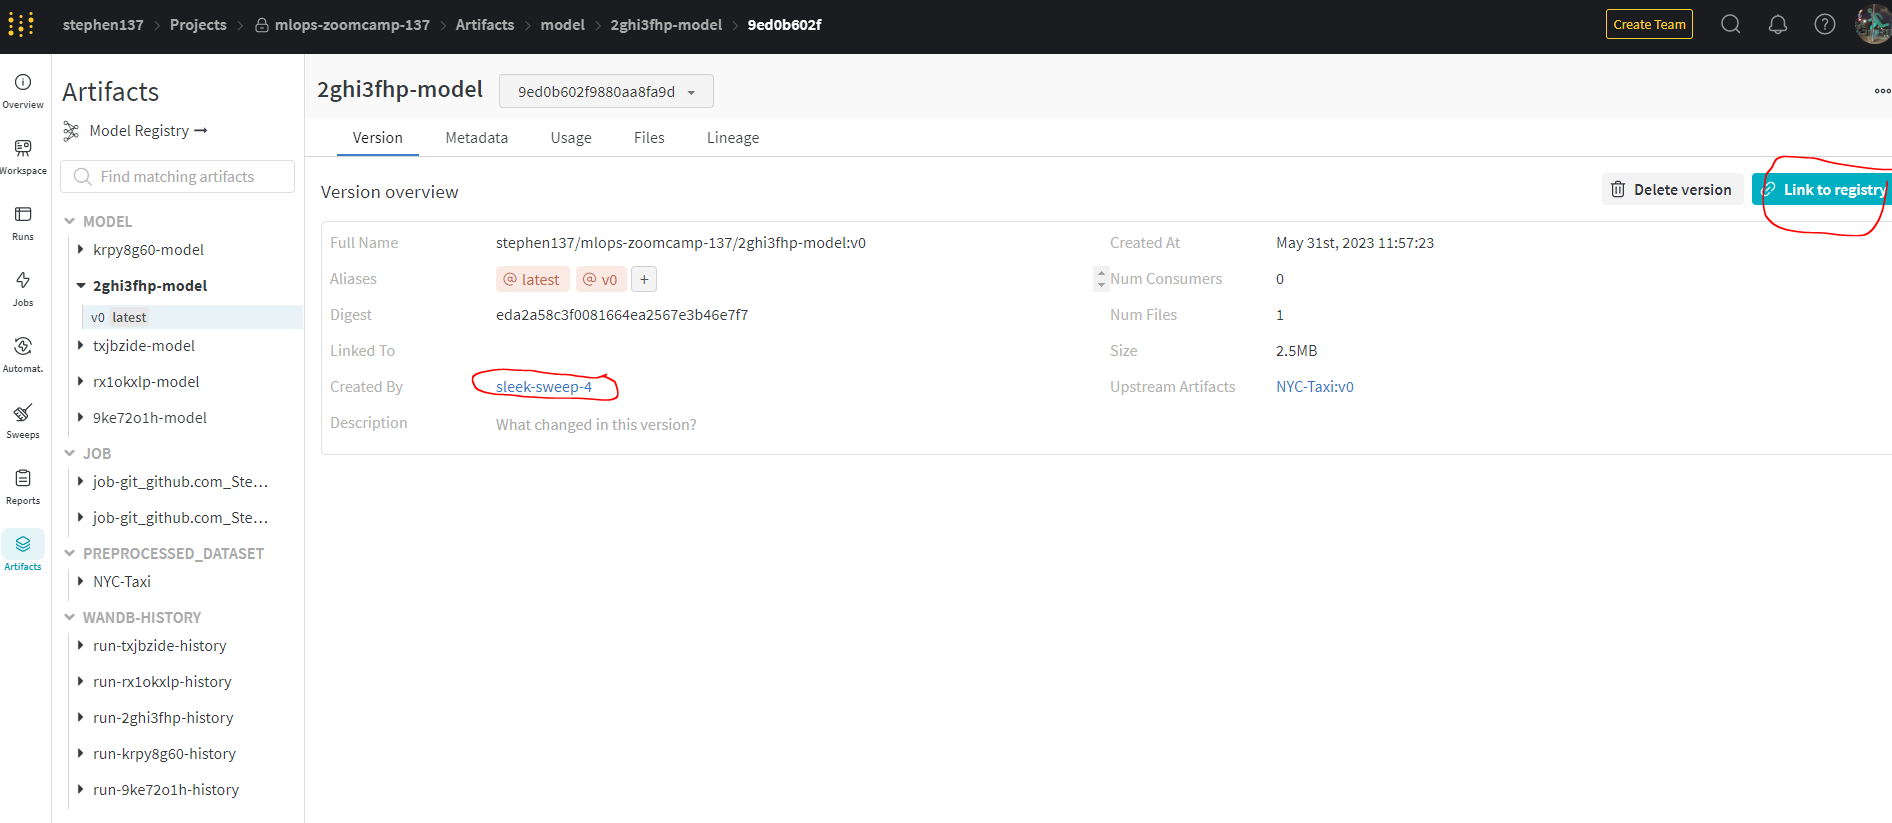


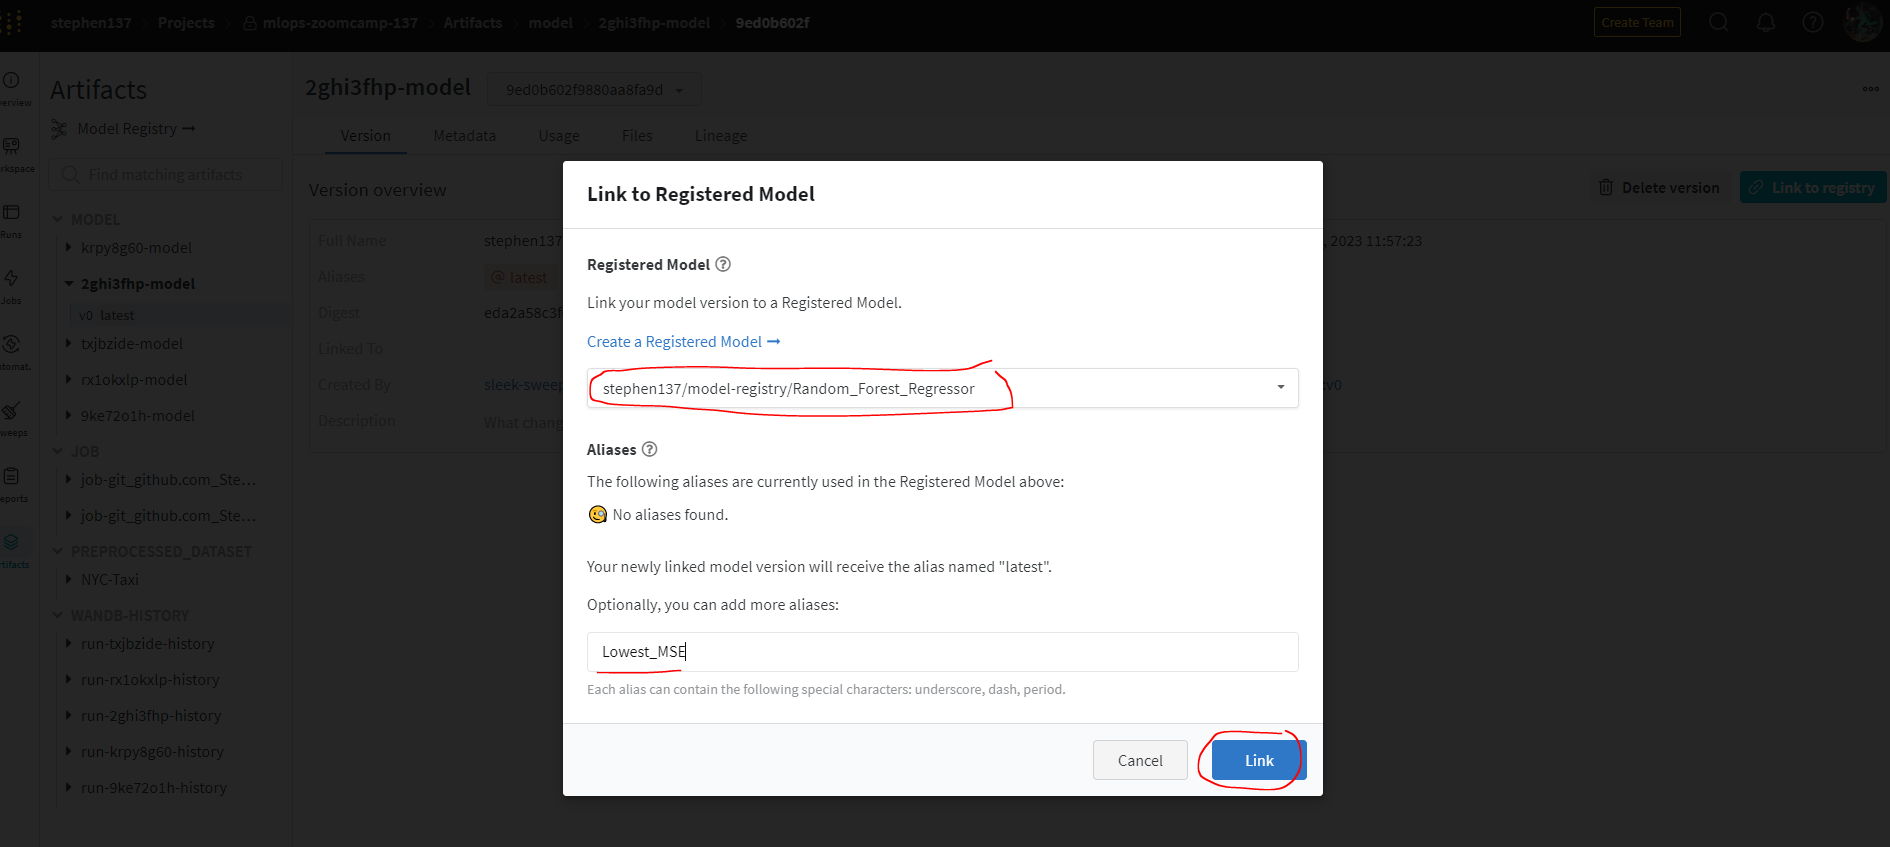


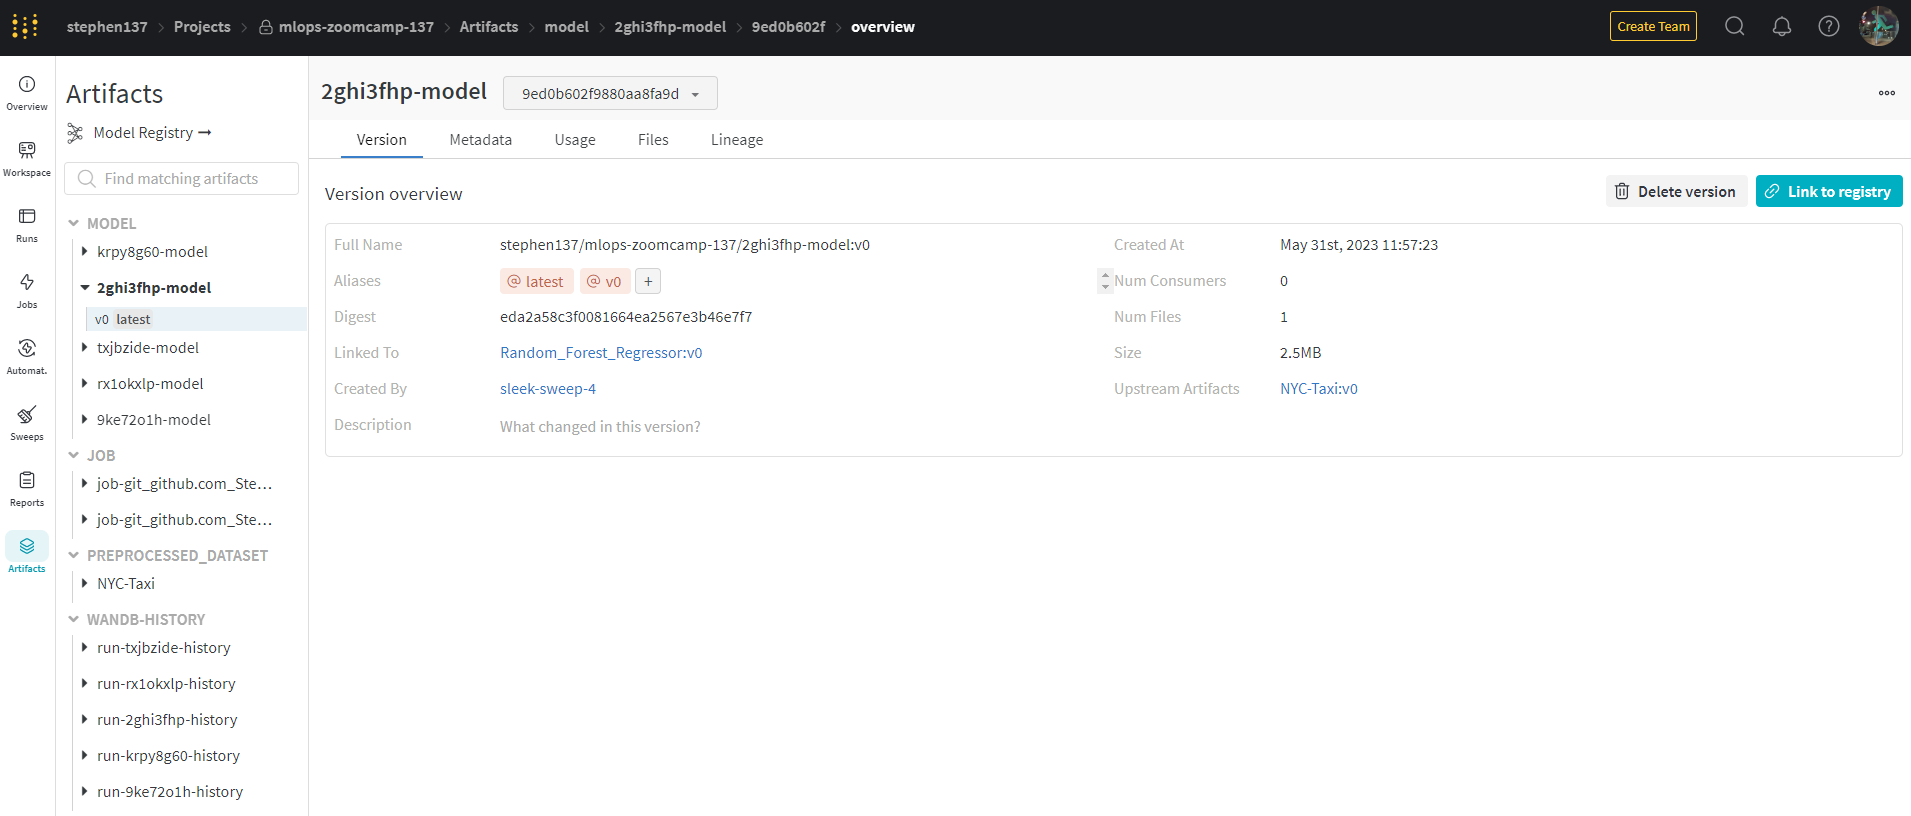


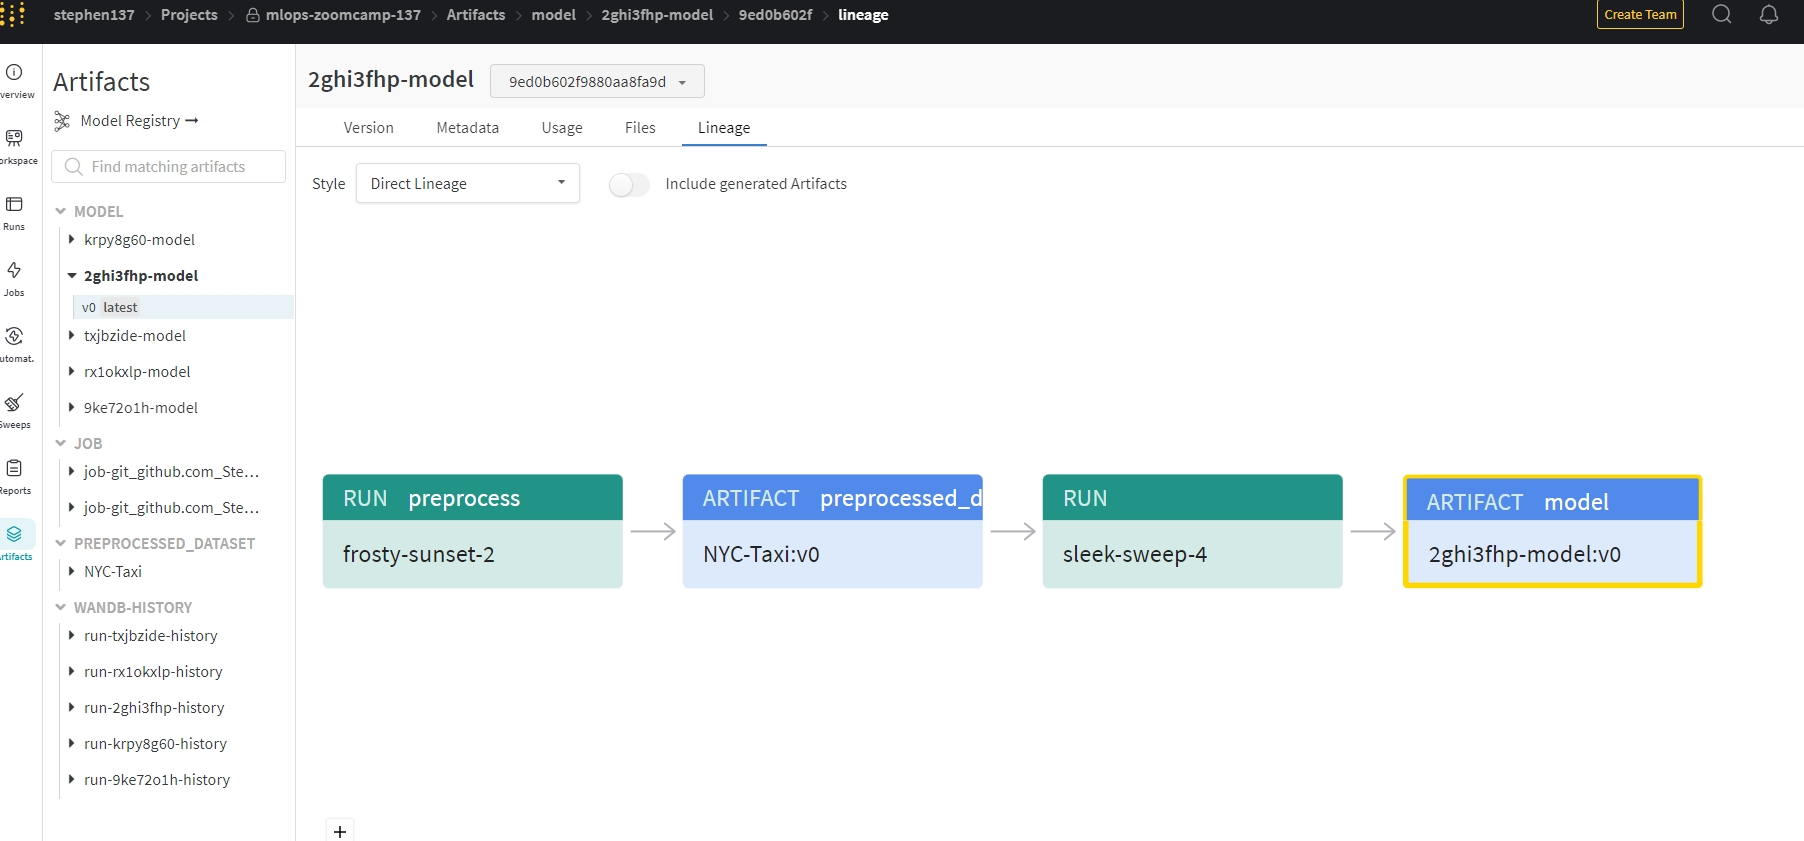

Now that the model artifact is linked to the Registered Model, which of these information do we see on the Registered Model UI?

- Versioning
- Metadata
- Aliases
- Metric (MSE)
- Source run
- `All of these`
- None of these